In [1]:
import datetime
import os, sys, shutil
import numpy as np
from numpy import loadtxt
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers, applications
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras import models
from tensorflow.keras.models import Model , load_model
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf
import time
import re
import seaborn as sns




In [2]:
batch_size = 16
epochs = 30
warmup_epocks = 2
learning_rate = 0.0005
warmup_learning_rate = 0.0001
height = 128
width = 128
colors = 3
n_classes = 5
es_patience = 5
rlrop_patience = 3
decay_drop = 0.5
based_model_last_block_layer_number = 5 

In [3]:
train_dir = 'C:/Users/asus/Desktop/images/train'
validation_dir = 'C:/Users/asus/Desktop/images/validation'

In [4]:

def build_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32,(3,3), activation='relu',input_shape=(height, width, colors)))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(32,(3,3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(64,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(128,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(128,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(1024,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(n_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.001)))

    return model 



In [5]:
model = build_model()
import tempfile
logdir = tempfile.mkdtemp()
print('Writing training logs to ' + logdir)


Writing training logs to C:\Users\asus\AppData\Local\Temp\tmpnc_je03f


In [6]:
%tensorboard --logdir={logdir}


UsageError: Line magic function `%tensorboard` not found.


In [7]:
callbacks = [tf.keras.callbacks.TensorBoard(log_dir=logdir, profile_batch=0)]


In [8]:
train_datagen = ImageDataGenerator(
      rescale=1/255,
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.5,
      brightness_range=[0.7,1.3],
      horizontal_flip=True,
      fill_mode='nearest')

In [9]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(height, width),
        batch_size= batch_size,
        shuffle = True,
        class_mode= 'categorical')

Found 2716 images belonging to 5 classes.


In [10]:
val_datagen = ImageDataGenerator(rescale=1/255)

val_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(height, width),
        batch_size = batch_size,
        shuffle=True,
        class_mode= 'categorical')

Found 941 images belonging to 5 classes.


In [11]:
from keras.layers import Flatten,MaxPooling2D,GlobalMaxPooling2D
from keras import regularizers
from tensorflow.keras.layers import BatchNormalization

Using TensorFlow backend.


In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint


for layer in model.layers[:based_model_last_block_layer_number]:
    layer.trainable = False
for layer in model.layers[based_model_last_block_layer_number:]:
    layer.trainable = True

metric_list = ["accuracy"]

es = EarlyStopping(monitor='val_loss', mode='min', patience=es_patience, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=rlrop_patience, factor=decay_drop, min_lr=1e-6, verbose=1)

step_train = train_generator.n//train_generator.batch_size
step_validation = val_generator.n//val_generator.batch_size

print(train_generator.n)


2716


In [15]:
optimizer = optimizers.Adam(lr=0.0005)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=['accuracy'])
    

In [16]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=step_train,
                              epochs=50,
                              verbose=1 ,
                              callbacks=callbacks,                            
                              validation_data=val_generator,
                              validation_steps=step_validation

                            ).history


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 169 steps, validate for 58 steps
Epoch 1/50
169/169 [==============================] - 884s 5s/step - loss: 2.0785 - accuracy: 0.5219 - val_loss: 2.7638 - val_accuracy: 0.1950
Epoch 2/50
169/169 [==============================] - 811s 5s/step - loss: 1.8483 - accuracy: 0.5856 - val_loss: 2.2893 - val_accuracy: 0.2414
Epoch 3/50
169/169 [==============================] - 802s 5s/step - loss: 1.6977 - accuracy: 0.6178 - val_loss: 1.3930 - val_accuracy: 0.7338
Epoch 4/50
169/169 [==============================] - 957s 6s/step - loss: 1.5971 - accuracy: 0.6341 - val_loss: 1.2667 - val_accuracy: 0.7586
Epoch 5/50
169/169 [==============================] - 900s 5s/step - loss: 1.5464 - accuracy: 0.6441 - val_loss: 1.2437 - val_accuracy: 0.7683
Epoch 6/50
169/169 [==============================] - 905s 5s/step - loss: 1.4797 - accuracy: 0.6544 - val_loss: 1.1669 - val_accuracy: 0.7683
Epoch 7/50
169/169 [=============================

In [ ]:
#callback_list = [es, rlrop,checkpointer]

In [17]:
train_data = pd.read_csv('C:/Users/asus/Desktop/retino/train.csv')
test_data = pd.read_csv('C:/Users/asus/Desktop/retino/test.csv')

train_path = 'C:/Users/asus/Desktop/retino/images/train'
test_path = 'C:/Users/asus/Desktop/retino/images/test'


In [20]:
def preprocess_image(image_path, desired_size=128):
    im = Image.open(image_path)
    im = im.resize((desired_size,) * 2, resample=Image.LANCZOS)

    return im
    
N = train_data.shape[0]

x_train = np.empty((N, 128, 128, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_data['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
        os.path.join(train_path + "/" + image_id + '.png')
    )

x_train = x_train / 255


100%|██████████| 3662/3662 [12:42<00:00,  4.80it/s]


In [21]:

# use the model to generate predictions for all of the training images
start = datetime.datetime.now()
print('Started predicting at {}'.format(start))

train_prediction = model.predict([x_train])

end = datetime.datetime.now()
elapsed = end - start
print('Predicting took a total of {}'.format(elapsed))

# take the highest predicted probability for each image
train_predictions = [np.argmax(pred) for pred in train_prediction]

Started predicting at 2020-04-20 09:56:19.829141
Predicting took a total of 0:00:15.878668


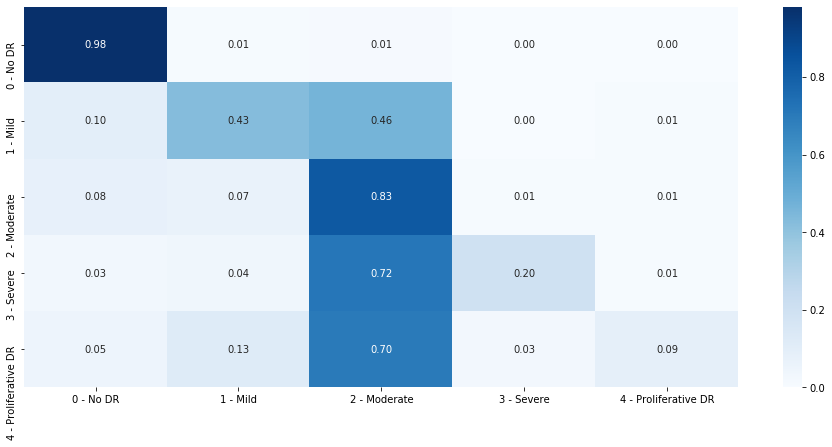

In [22]:
# look at how the model performed for each class
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train_data['diagnosis'].astype('int'), train_predictions)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

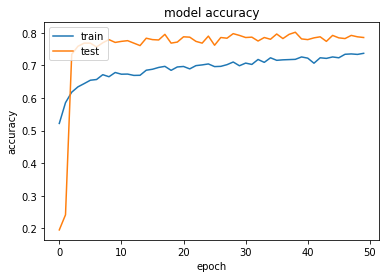

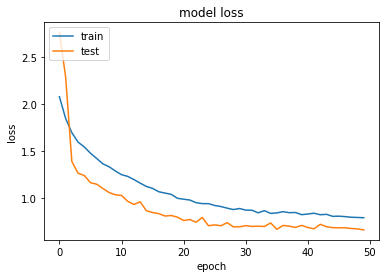

In [23]:

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        1

In [25]:
# Backend agnostic way to save/restore models
_, keras_file = tempfile.mkstemp('.h5')
print('Saving model to: ', keras_file)
tf.keras.models.save_model(model, keras_file, include_optimizer=False)

Saving model to:  C:\Users\asus\AppData\Local\Temp\tmp56zb93eo.h5


In [27]:
from tensorflow_model_optimization.sparsity import keras as sparsity

In [28]:
import numpy as np

epochs = 10
num_train_samples = x_train.shape[0]
end_step = np.ceil(1.0 * num_train_samples / train_generator.batch_size).astype(np.int32) * epochs
print('End step: ' + str(end_step))

End step: 2290


In [29]:
pruning_params = {
      'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.50,
                                                   final_sparsity=0.90,
                                                   begin_step=0,
                                                   end_step=end_step)
}

In [30]:

l = tf.keras.layers

pruned_model = tf.keras.Sequential([
    sparsity.prune_low_magnitude( l.Conv2D(32,(3,3), activation='relu'), input_shape=(height, width, colors), **pruning_params),
    l.MaxPooling2D((2, 2)),
    l.BatchNormalization(),
    
    sparsity.prune_low_magnitude(l.Conv2D(32, (3,3), activation='relu'), **pruning_params),
    l.MaxPooling2D((2, 2)),

    l.BatchNormalization(),
    sparsity.prune_low_magnitude(l.Conv2D(64, (3,3), activation='relu'), **pruning_params),
    l.MaxPooling2D((2, 2)),

    
    l.BatchNormalization(),
    sparsity.prune_low_magnitude(l.Conv2D(128, (3,3), activation='relu'), **pruning_params),
    l.MaxPooling2D((2, 2)),

    l.BatchNormalization(),
    sparsity.prune_low_magnitude(l.Conv2D(128, (3,3), activation='relu'), **pruning_params),


    l.MaxPooling2D((2, 2)),
    l.Flatten(),
    sparsity.prune_low_magnitude(l.Dense(1024, activation='relu'),**pruning_params),
    l.Dropout(0.5),
    sparsity.prune_low_magnitude(l.Dense(n_classes, activation='softmax'), **pruning_params)
])


Instructions for updating:
Please use `layer.add_weight` method instead.


In [31]:
logdir = tempfile.mkdtemp()
print('Writing training logs to ' + logdir)

Writing training logs to C:\Users\asus\AppData\Local\Temp\tmphyuqxcaf


In [32]:
%tensorboard --logdir={logdir}

UsageError: Line magic function `%tensorboard` not found.


In [33]:
pruned_model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy'])
#pruned_model.compile(
 #   loss=tf.keras.losses.binary_crossentropy,
  #  optimizer='adam',
   # metrics=['accuracy'])

In [34]:

# Add a pruning step callback to peg the pruning step to the optimizer's
# step. Also add a callback to add pruning summaries to tensorboard
callbacks = [
    sparsity.UpdatePruningStep(),
    sparsity.PruningSummaries(log_dir=logdir, profile_batch=0)
]

history_1 = pruned_model.fit(train_generator,
          steps_per_epoch=step_train,
          epochs=5,
          verbose=1,
          callbacks=callbacks,
          validation_data=val_generator).history
          

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 169 steps, validate for 59 steps
Epoch 1/5
168/169 [============================>.] - ETA: 2s - loss: 1.2670 - accuracy: 0.5414INFO:tensorflow:Summary name prune_low_magnitude_conv2d_5/mask:0/sparsity is illegal; using prune_low_magnitude_conv2d_5/mask_0/sparsity instead.
INFO:tensorflow:Summary name prune_low_magnitude_conv2d_6/mask:0/sparsity is illegal; using prune_low_magnitude_conv2d_6/mask_0/sparsity instead.
INFO:tensorflow:Summary name prune_low_magnitude_conv2d_7/mask:0/sparsity is illegal; using prune_low_magnitude_conv2d_7/mask_0/sparsity instead.
INFO:tensorflow:Summary name prune_low_magnitude_conv2d_8/mask:0/sparsity is illegal; using prune_low_magnitude_conv2d_8/mask_0/sparsity instead.
INFO:tensorflow:Summary name prune_low_magnitude_conv2d_9/mask:0/sparsity is illegal; using prune_low_magnitude_conv2d_9/mask_0/sparsity instead.
INFO:tensorflow:Summary name prune_low_magnitude_dense_2/mask:0/sparsity is illegal

In [35]:
pruned_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d_5 (None, 126, 126, 32)      1762      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 63, 63, 32)        128       
_________________________________________________________________
prune_low_magnitude_conv2d_6 (None, 61, 61, 32)        18466     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
prune_low_magnitude_conv2d_7 (None, 28, 28, 64)       

In [36]:
_, checkpoint_file = tempfile.mkstemp('.h5')
print('Saving pruned model to: ', checkpoint_file)
# saved_model() sets include_optimizer to True by default. Spelling it out here
# to highlight.
tf.keras.models.save_model(pruned_model, checkpoint_file, include_optimizer=True)

with sparsity.prune_scope():
  restored_model = tf.keras.models.load_model(checkpoint_file)

callbacks = [
    sparsity.UpdatePruningStep(),
    sparsity.PruningSummaries(log_dir=logdir, profile_batch=0)
]

history_2 = restored_model.fit(train_generator,
                    steps_per_epoch=step_train,
                   epochs=5,
                   verbose=1,
                   callbacks=callbacks,
                   validation_data=val_generator).history


Saving pruned model to:  C:\Users\asus\AppData\Local\Temp\tmp6cpaycfk.h5
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 169 steps, validate for 59 steps
Epoch 1/5
168/169 [============================>.] - ETA: 2s - loss: 0.8765 - accuracy: 0.6811INFO:tensorflow:Summary name prune_low_magnitude_conv2d_5_1/mask:0/sparsity is illegal; using prune_low_magnitude_conv2d_5_1/mask_0/sparsity instead.
INFO:tensorflow:Summary name prune_low_magnitude_conv2d_6_1/mask:0/sparsity is illegal; using prune_low_magnitude_conv2d_6_1/mask_0/sparsity instead.
INFO:tensorflow:Summary name prune_low_magnitude_conv2d_7_1/mask:0/sparsity is illegal; using prune_low_magnitude_conv2d_7_1/mask_0/sparsity instead.
INFO:tensorflow:Summary name prune_low_magnitude_conv2d_8_1/mask:0/sparsity is illegal; using prune_low_magnitude_conv2d_8_1/mask_0/sparsity instead.
INFO:tensorflow:Summary name prune_low_magnitude_conv2d_9_1/mask:0/sparsity is illegal; using prune_low_magnitude_conv2d_9_1/mask_0/sparsity

In [37]:
restored_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d_5 (None, 126, 126, 32)      1762      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 63, 63, 32)        128       
_________________________________________________________________
prune_low_magnitude_conv2d_6 (None, 61, 61, 32)        18466     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
prune_low_magnitude_conv2d_7 (None, 28, 28, 64)       

In [38]:
final_model = sparsity.strip_pruning(pruned_model)
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 63, 63, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)       

Started predicting at 2020-04-20 11:36:47.027249
Predicting took a total of 0:00:10.254582


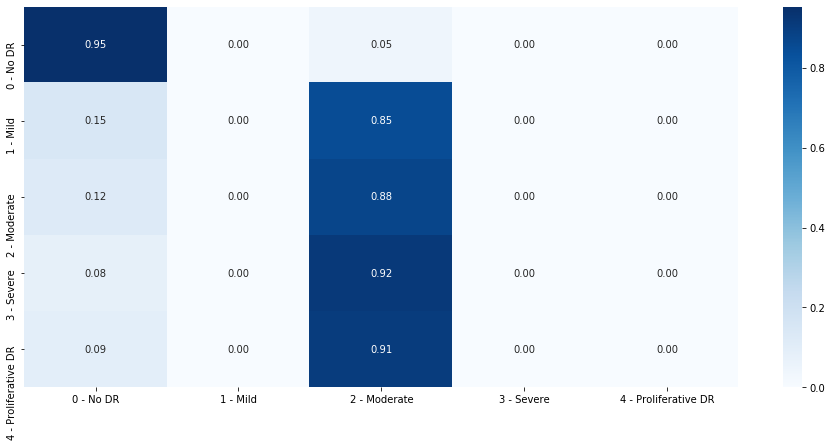

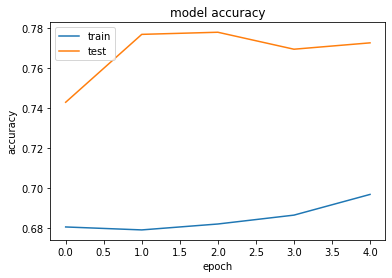

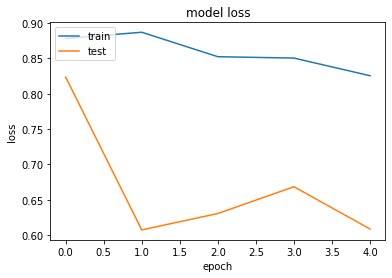

In [39]:

# use the model to generate predictions for all of the training images
start = datetime.datetime.now()
print('Started predicting at {}'.format(start))

train_prediction = final_model.predict([x_train])

end = datetime.datetime.now()
elapsed = end - start
print('Predicting took a total of {}'.format(elapsed))

# take the highest predicted probability for each image
train_predictions = [np.argmax(pred) for pred in train_prediction]

# look at how the model performed for each class
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train_data['diagnosis'].astype('int'), train_predictions)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()
import matplotlib.pyplot as plt

plt.plot(history_2['accuracy'])
plt.plot(history_2['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_2['loss'])
plt.plot(history_2['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [40]:
_, pruned_keras_file = tempfile.mkstemp('.h5')
print('Saving pruned model to: ', pruned_keras_file)

# No need to save the optimizer with the graph for serving.
tf.keras.models.save_model(final_model, pruned_keras_file, include_optimizer=False)

Saving pruned model to:  C:\Users\asus\AppData\Local\Temp\tmp21e_a5sq.h5


In [41]:
_, zip1 = tempfile.mkstemp('.zip') 
with zipfile.ZipFile(zip1, 'w', compression=zipfile.ZIP_DEFLATED) as f:
  f.write(keras_file)
print("Size of the unpruned model before compression: %.2f Mb" % 
      (os.path.getsize(keras_file) / float(2**20)))
print("Size of the unpruned model after compression: %.2f Mb" % 
      (os.path.getsize(zip1) / float(2**20)))

_, zip2 = tempfile.mkstemp('.zip') 
with zipfile.ZipFile(zip2, 'w', compression=zipfile.ZIP_DEFLATED) as f:
  f.write(pruned_keras_file)
print("Size of the pruned model before compression: %.2f Mb" % 
      (os.path.getsize(pruned_keras_file) / float(2**20)))
print("Size of the pruned model after compression: %.2f Mb" % 
      (os.path.getsize(zip2) / float(2**20)))



Size of the unpruned model before compression: 3.04 Mb
Size of the unpruned model after compression: 2.81 Mb
Size of the pruned model before compression: 3.03 Mb
Size of the pruned model after compression: 0.91 Mb


In [42]:
# Load the serialized model
loaded_model = tf.keras.models.load_model(keras_file)

In [43]:
epochs = 4
end_step = np.ceil(1.0 * num_train_samples / batch_size).astype(np.int32) * epochs
print(end_step)

new_pruning_params = {
      'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.10,
                                                   final_sparsity=0.50,
                                                   begin_step=0,
                                                   end_step=end_step,
                                                   frequency=100)
}

new_pruned_model = sparsity.prune_low_magnitude(model, **new_pruning_params)
new_pruned_model.summary()

new_pruned_model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy'])

#new_pruned_model.compile(
 #   loss=tf.keras.losses.binary_crossentropy,
  #  optimizer='adam',
   # metrics=['accuracy'])    


916
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d ( (None, 126, 126, 32)      1762      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 63, 63, 32)        1         
_________________________________________________________________
prune_low_magnitude_batch_no (None, 63, 63, 32)        129       
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 61, 61, 32)        18466     
_________________________________________________________________
prune_low_magnitude_max_pool (None, 30, 30, 32)        1         
_________________________________________________________________
prune_low_magnitude_batch_no (None, 30, 30, 32)        129       
_________________________________________________________________
prune_low_magnitude_conv2d_2 (None, 28, 28, 64)     

In [44]:
logdir = tempfile.mkdtemp()
print('Writing training logs to ' + logdir)

Writing training logs to C:\Users\asus\AppData\Local\Temp\tmp_o1dsbnd


In [45]:
%tensorboard --logdir={logdir}

UsageError: Line magic function `%tensorboard` not found.


In [46]:
# Add a pruning step callback to peg the pruning step to the optimizer's
# step. Also add a callback to add pruning summaries to tensorboard
callbacks = [
    sparsity.UpdatePruningStep(),
    sparsity.PruningSummaries(log_dir=logdir, profile_batch=0)
]

history_3 = new_pruned_model.fit(train_generator,
          steps_per_epoch=step_train,
          epochs=10,
          verbose=1,
          callbacks=callbacks,
          validation_data=val_generator).history

#score = new_pruned_model.evaluate(x_test, y_test, verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

mary name prune_low_magnitude_dense_1/mask:0/sparsity is illegal; using prune_low_magnitude_dense_1/mask_0/sparsity instead.
INFO:tensorflow:Summary name prune_low_magnitude_conv2d/threshold:0/threshold is illegal; using prune_low_magnitude_conv2d/threshold_0/threshold instead.
INFO:tensorflow:Summary name prune_low_magnitude_conv2d_1/threshold:0/threshold is illegal; using prune_low_magnitude_conv2d_1/threshold_0/threshold instead.
INFO:tensorflow:Summary name prune_low_magnitude_conv2d_2/threshold:0/threshold is illegal; using prune_low_magnitude_conv2d_2/threshold_0/threshold instead.
INFO:tensorflow:Summary name prune_low_magnitude_conv2d_3/threshold:0/threshold is illegal; using prune_low_magnitude_conv2d_3/threshold_0/threshold instead.
INFO:tensorflow:Summary name prune_low_magnitude_conv2d_4/threshold:0/threshold is illegal; using prune_low_magnitude_conv2d_4/threshold_0/threshold instead.
INFO:tensorflow:Summary name prune_low_magnitude_dense/threshold:0/threshold is illegal; 

In [47]:

# use the model to generate predictions for all of the training images
start = datetime.datetime.now()
print('Started predicting at {}'.format(start))

train_prediction = new_pruned_model.predict([x_train])

end = datetime.datetime.now()
elapsed = end - start
print('Predicting took a total of {}'.format(elapsed))

# take the highest predicted probability for each image
train_predictions = [np.argmax(pred) for pred in train_prediction]



Started predicting at 2020-04-20 13:15:14.780107
Predicting took a total of 0:00:13.240893


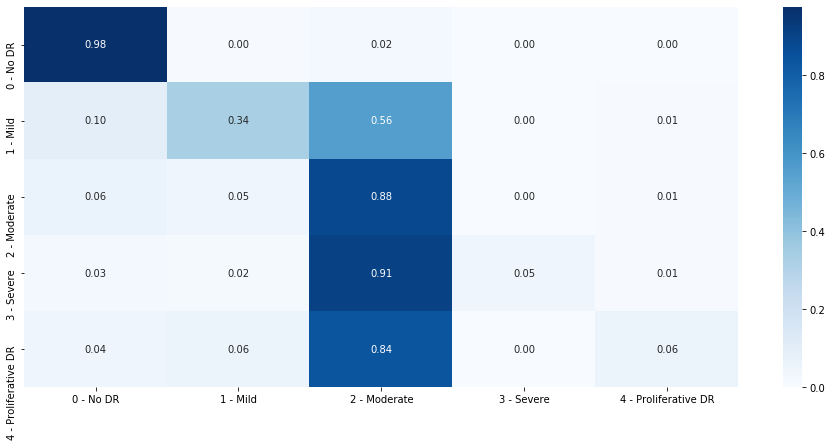

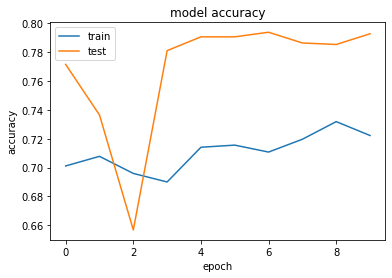

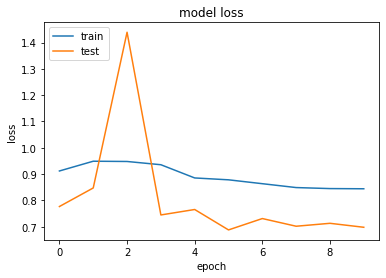

In [48]:

# look at how the model performed for each class
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train_data['diagnosis'].astype('int'), train_predictions)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()
import matplotlib.pyplot as plt

plt.plot(history_3['accuracy'])
plt.plot(history_3['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_3['loss'])
plt.plot(history_3['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [49]:
new_pruned_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d ( (None, 126, 126, 32)      1762      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 63, 63, 32)        1         
_________________________________________________________________
prune_low_magnitude_batch_no (None, 63, 63, 32)        129       
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 61, 61, 32)        18466     
_________________________________________________________________
prune_low_magnitude_max_pool (None, 30, 30, 32)        1         
_________________________________________________________________
prune_low_magnitude_batch_no (None, 30, 30, 32)        129       
_________________________________________________________________
prune_low_magnitude_conv2d_2 (None, 28, 28, 64)        3

In [50]:
final_model = sparsity.strip_pruning(pruned_model)
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 63, 63, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)       

Started predicting at 2020-04-20 13:15:33.258659
Predicting took a total of 0:00:09.996113


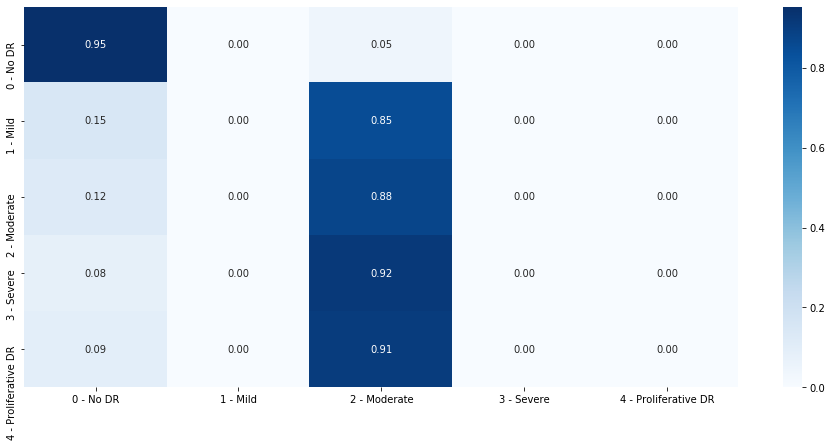

In [51]:

# use the model to generate predictions for all of the training images
start = datetime.datetime.now()
print('Started predicting at {}'.format(start))

train_prediction = final_model.predict([x_train])

end = datetime.datetime.now()
elapsed = end - start
print('Predicting took a total of {}'.format(elapsed))

# take the highest predicted probability for each image
train_predictions = [np.argmax(pred) for pred in train_prediction]

# look at how the model performed for each class
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train_data['diagnosis'].astype('int'), train_predictions)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()



In [52]:
_, new_pruned_keras_file = tempfile.mkstemp('.h5')
print('Saving pruned model to: ', new_pruned_keras_file)
tf.keras.models.save_model(final_model, new_pruned_keras_file, 
                        include_optimizer=False)

Saving pruned model to:  C:\Users\asus\AppData\Local\Temp\tmphs9169bu.h5


In [53]:
_, zip3 = tempfile.mkstemp('.zip')
with zipfile.ZipFile(zip3, 'w', compression=zipfile.ZIP_DEFLATED) as f:
  f.write(new_pruned_keras_file)
print("Size of the pruned model before compression: %.2f Mb" 
      % (os.path.getsize(new_pruned_keras_file) / float(2**20)))
print("Size of the pruned model after compression: %.2f Mb" 
      % (os.path.getsize(zip3) / float(2**20)))

Size of the pruned model before compression: 3.03 Mb
Size of the pruned model after compression: 0.91 Mb


## ** Quantization:**

In [ ]:
tflite_model_file = '/tmp/sparse_scratch.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model_file(pruned_keras_file)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()
with open(tflite_model_file, 'wb') as f:
  f.write(tflite_model)

In [ ]:
_, zip_tflite = tempfile.mkstemp('.zip')
with zipfile.ZipFile(zip_tflite, 'w', compression=zipfile.ZIP_DEFLATED) as f:
  f.write(tflite_model_file)
print("Size of the tflite model before compression: %.2f Mb" 
      % (os.path.getsize(tflite_model_file) / float(2**20)))
print("Size of the tflite model after compression: %.2f Mb" 
      % (os.path.getsize(zip_tflite) / float(2**20)))

In [ ]:

interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

def eval_model(interpreter,test_path):
  total_seen = 0
  num_correct = 0

  for img, label in zip(test_path):
    inp = img.reshape((1, 28, 28, 1))
    total_seen += 1
    interpreter.set_tensor(input_index, inp)
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_index)
    if np.argmax(predictions) == np.argmax(label):
      num_correct += 1

    if total_seen % 1000 == 0:
        print("Accuracy after %i images: %f" %
              (total_seen, float(num_correct) / float(total_seen)))

  return float(num_correct) / float(total_seen)

print(eval_model(interpreter, test_path))

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model_file(pruned_keras_file)

converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

tflite_quant_model = converter.convert()

tflite_quant_model_file = '/tmp/sparse_mnist_quant.tflite'
with open(tflite_quant_model_file, 'wb') as f:
  f.write(tflite_quant_model)

In [ ]:
_, zip_tflite = tempfile.mkstemp('.zip')
with zipfile.ZipFile(zip_tflite, 'w', compression=zipfile.ZIP_DEFLATED) as f:
  f.write(tflite_quant_model_file)
print("Size of the tflite model before compression: %.2f Mb" 
      % (os.path.getsize(tflite_quant_model_file) / float(2**20)))
print("Size of the tflite model after compression: %.2f Mb" 
      % (os.path.getsize(zip_tflite) / float(2**20)))

In [ ]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_quant_model_file))
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

print(eval_model(interpreter, test_path))